# `nplotter`: a Jupyter Notebook that creates fun plots of Spotify listening data!

A while back I requested my listening data from Spotify (an online streaming service). Once I got my data, I decided that I wanted to figure out some personal trends that I had and was thinking of a few fun plots to make along the way. These plots are as follows:

- Top 100 Artists
- Monthly listening
- Peak listening for top artists
- Typical weekly listening habits

Below is my code to make this all work, but before you run this you will need the following packages installed:
- `numpy`
- `pandas`
- `matplotlib`
- `seaborn` 

Or you can use the conda environment file to create a virtual environment that can run this notebook!

In [1]:
import os
import numpy as np
import datetime
import itertools
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.set_context('talk')
sns.set_style('whitegrid')

This next section goes through the current directory, finds all of our `StreamingHistoryX.json` files and converts them into a `pandas.DataFrame`

In [2]:
streaming_files = sorted([f for f in os.listdir('.') if 'StreamingHistory' in f])
df = pd.read_json(streaming_files[0])
for streaming_file in streaming_files[1:]:
    df = df.append(pd.read_json(streaming_file)) 

In [3]:
df.reset_index(inplace=True) #resets indicies since this is multiple combined dataframes
df.sort_values(by='endTime', inplace=True) # sorts by date
total_played= df.groupby(['artistName']).msPlayed.sum() / 60000 # Divide by 60,000 to get from ms to min
total_played.sort_values(inplace=True)

# Top 100 Artists
Now I wanted to see what my total listening was for my top 100 artists. I did ths by creating a simple bar chart.

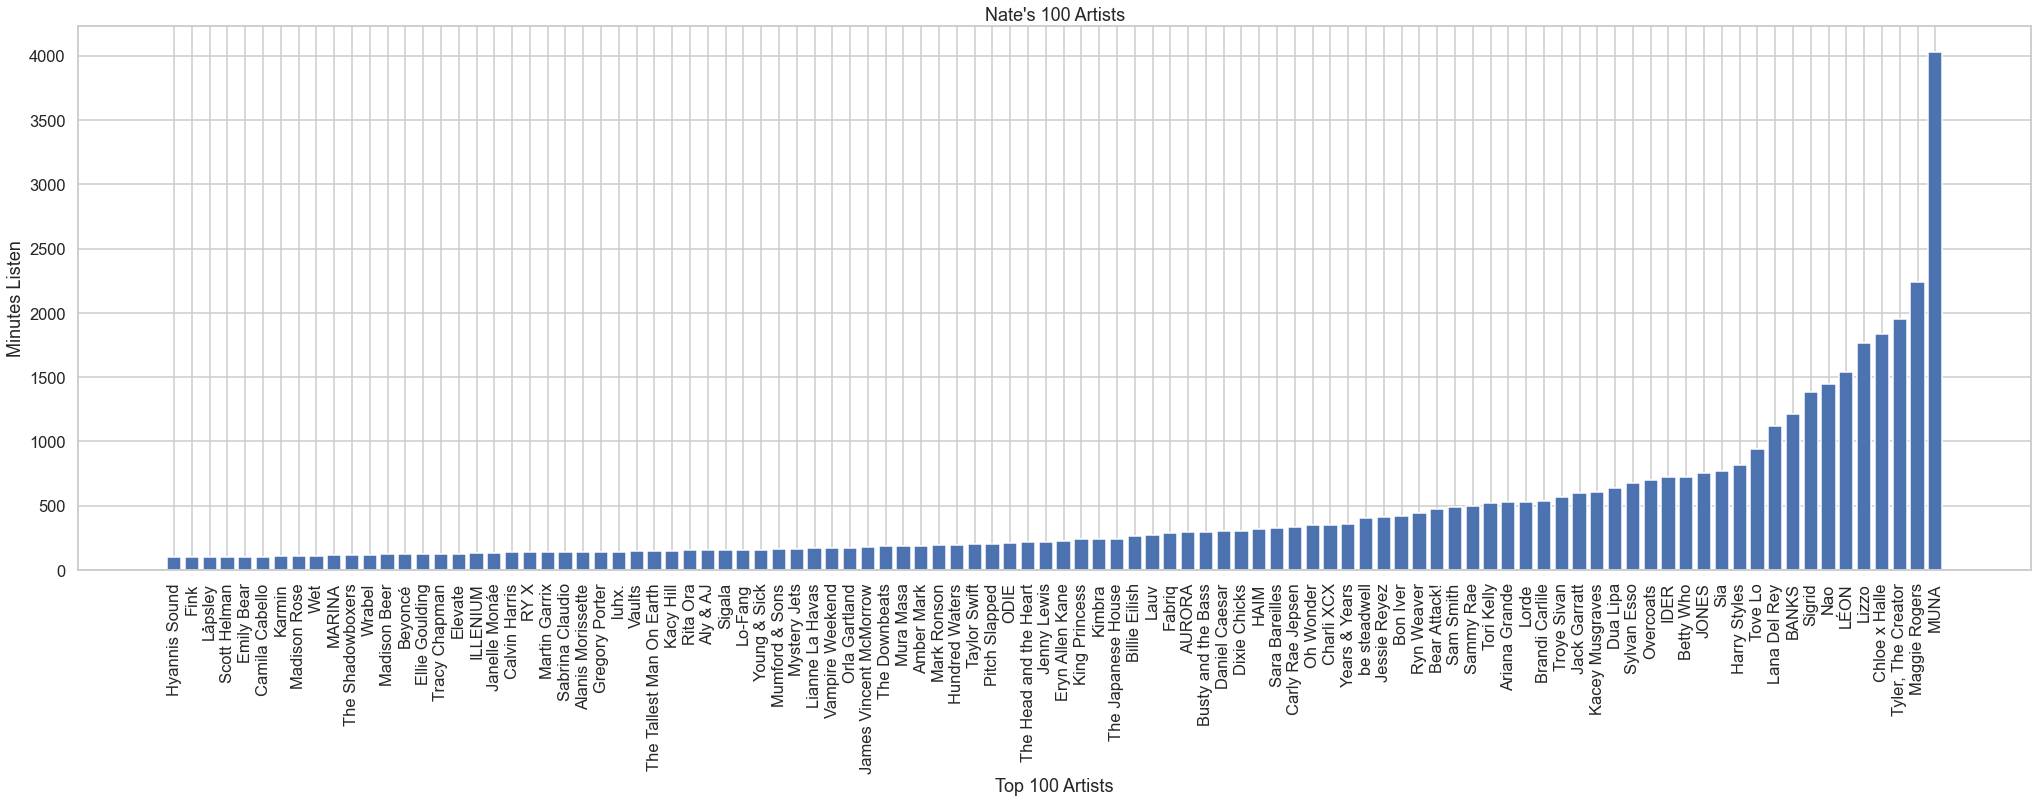

In [4]:
fig, ax = plt.subplots(figsize=(35,10))
ax.bar(x=total_played.iloc[-100:].index, height=total_played.iloc[-100:].values)
plt.xticks(rotation=90)
ax.set_xlabel('Top 100 Artists')
ax.set_ylabel('Minutes Listen')
ax.set_title('Nate\'s 100 Artists')
plt.savefig('top-100.pdf', bbox_inches='tight')

# Monthly listening 

Next I wanted to see how many minutes of music I was listening to over the months. First we had to get the month that each song was listened to and then plot over those months.

In [5]:
def get_month(x):
    """
    A helper function to convert endTime in our dataframe to a YYYY-MM format
    """
    dt = datetime.datetime.strptime(x, '%Y-%m-%d %H:%M')
    return f'{dt.year}-{str(dt.month).zfill(2)}'
    

In [6]:
# Adding a new column that has our `year-month` data
df['year-month'] = df.endTime.apply(get_month)
df.iloc[:5]

,index,endTime,artistName,trackName,msPlayed,year-month
0,0,2019-02-20 01:12,Nao,If You Ever (feat. 6LACK),221735,2019-02
1,1,2019-02-20 01:16,Nao,Make It Out Alive (feat. SiR),212750,2019-02
2,2,2019-02-20 01:19,Calvin Harris,Promises (with Sam Smith),1312,2019-02
3,3,2019-02-20 01:19,Sam Smith,Dancing With A Stranger (with Normani),171029,2019-02
4,4,2019-02-20 01:22,Sam Smith,Dancing With A Stranger (with Normani),171456,2019-02


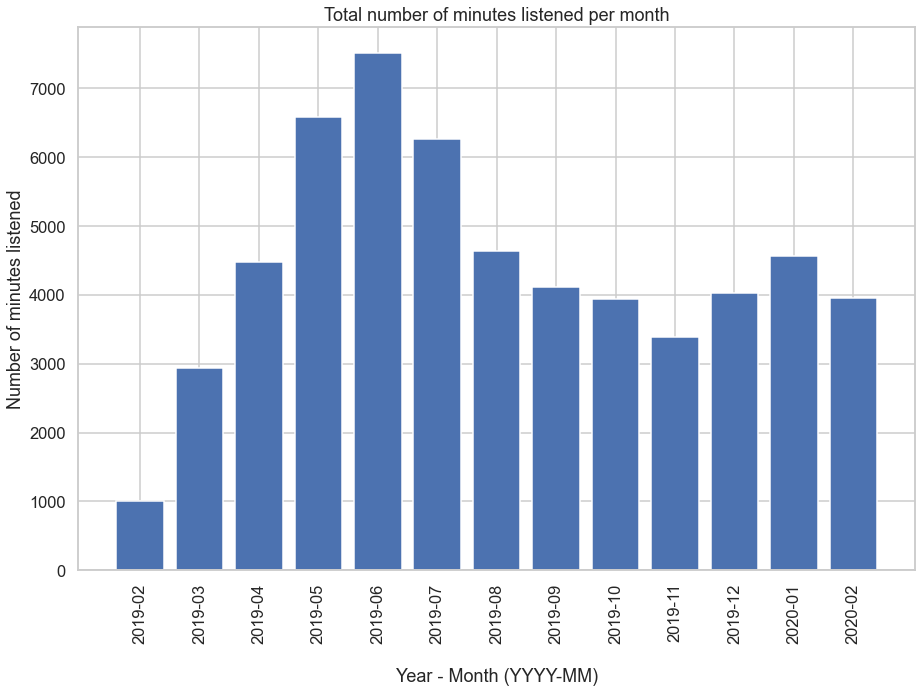

In [7]:
months = []
min_listened = []
for ym, small_df in df.groupby(['year-month']):
    months.append(ym)
    min_listened.append(small_df.msPlayed.sum() / 60000)
    
fig, ax = plt.subplots(figsize=(15,10))
ax.bar(months, min_listened)
plt.xticks(rotation=90)
ax.set_ylabel('Number of minutes listened')
ax.set_xlabel('\nYear - Month (YYYY-MM)')
ax.set_title('Total number of minutes listened per month')
plt.savefig('monthly.pdf', bbox_inches='tight')

# Top 25 artist peaks

Next, I wanted to look at my listening over the months for my top artists. So I selected my top 25 artists to look at and looked at my listeing for them over the months

In [8]:
artists_to_consider = total_played.index[-25:] # selecting the top 25 artists
print('We will be considering the following artists:')
for artist in artists_to_consider:
    print('\t- {}'.format(artist))

We will be considering the following artists:
	- Ariana Grande
	- Lorde
	- Brandi Carlile
	- Troye Sivan
	- Jack Garratt
	- Kacey Musgraves
	- Dua Lipa
	- Sylvan Esso
	- Overcoats
	- IDER
	- Betty Who
	- JONES
	- Sia
	- Harry Styles
	- Tove Lo
	- Lana Del Rey
	- BANKS
	- Sigrid
	- Nao
	- LÉON
	- Lizzo
	- Chloe x Halle
	- Tyler, The Creator
	- Maggie Rogers
	- MUNA


Next, we want to create an `OrderedDict` with keys being artist names and values of `OrderedDict`s with keys of year-month and values of minutes listened to over that month

In [9]:
from collections import OrderedDict

results_dict = OrderedDict()
for artist in artists_to_consider:
    results_dict[artist] = OrderedDict()
    for ym in df['year-month'].unique():
        results_dict[artist][ym] = 0

Then grouping our `DataFrame` by date and by artist and setting the results accordingly

In [10]:
grouped_df = df[df.artistName.apply(lambda x: x in artists_to_consider)].groupby(['year-month', 'artistName'])
for (ym, artist), small_df in grouped_df:
    results_dict[artist][ym]= small_df.msPlayed.sum() / 60000 # 60000 ms in a min

Because I wanted to study peaks in listening to these artists, so I removed artists that didn't have a peak of over 360 min in a single month period. 

In [11]:
to_del = []
min_minutes = 360 # change this if your peaks are smaller than mine.
for artist, artist_dict in results_dict.items():
    if max(list(artist_dict.values())) < min_minutes:
        to_del.append(artist)
        
for d in to_del:
    del results_dict[d]

Finally, I created the artist peak plot!

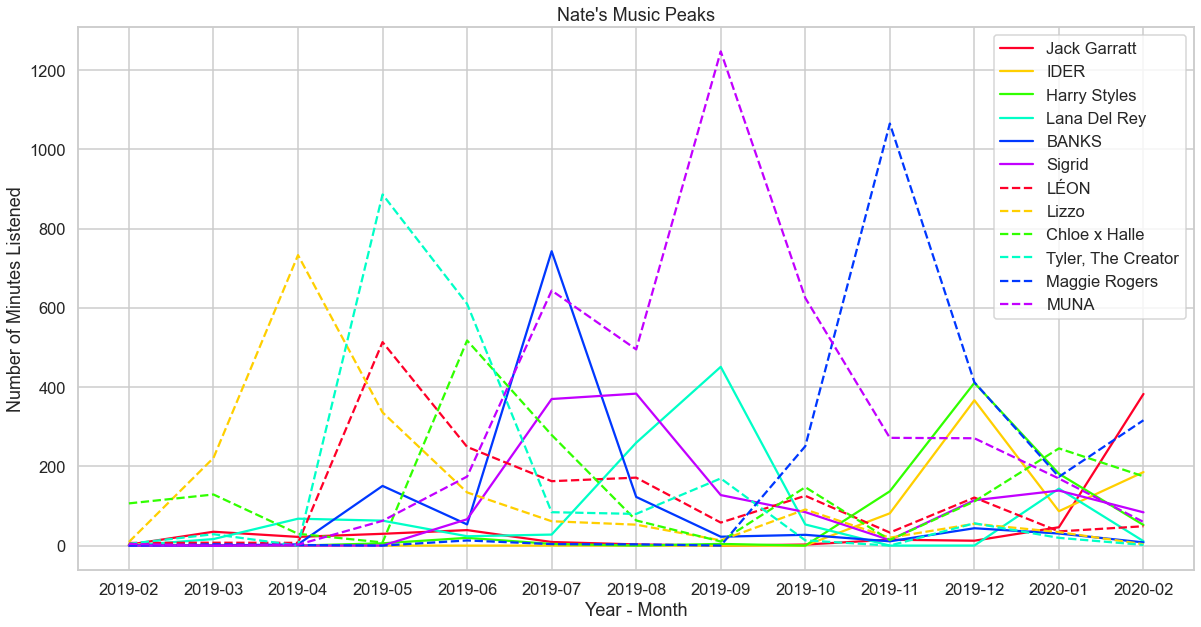

In [12]:
fig, ax = plt.subplots(figsize=(20,10))
cm = plt.get_cmap('gist_rainbow') # sets pretty colors from a color pallet 
colors = [cm(i/5.5) for i in range(6)] # gets a gamut of colors 
linestyles = ['-','--','-.',':'] # uses a variety of line styles
combos = list(itertools.product(linestyles, colors)) # creates all possible combinations of colors and line styles

for i, (artist_name, artist_dict) in enumerate(results_dict.items()):
    ls, c = combos[i]
    ax.plot(
        range(len(artist_dict.keys())), # a range for plotting, this will be changed
        list(artist_dict.values()), # the min listened over months
        label=artist_name,
        color=c, 
        linestyle=ls)
    
ax.legend()
# resetting the xticks to the year-months
ax.set_xticks(range(len(artist_dict.keys()))) 
ax.set_xticklabels(list(artist_dict.keys()))


ax.set_ylabel('Number of Minutes Listened')
ax.set_xlabel('Year - Month')
ax.set_title('Nate\'s Music Peaks')
plt.savefig('peaks.pdf', bbox_inches='tight')

# Weekly listening habits

Next, I wanted to see how my listening habits fluxuated over each day of the week. Essentailly I wanted to see if there were any times of the week were I was listing to a lot of or very little music. 

First, we had to figure our the day of the week and the hour that each song was listened to in so we made two functions to help us with that and applied them to our DataFrame

In [13]:
def get_weekday(x):
    """
    A helper function tos convert endTime into the weekday that a song was listened to
    """
    dt = datetime.datetime.strptime(x, '%Y-%m-%d %H:%M')
    return dt.weekday()

def get_hour(x):
    """
    A helper function to get the hour in the day a song was listened to
    """
    dt = datetime.datetime.strptime(x, '%Y-%m-%d %H:%M')
    return dt.hour

# creating columns for weekday and hour and grouping our DataFrame by these.
df['weekday'] = df.endTime.apply(get_weekday) 
df['hour'] = df.endTime.apply(get_hour)
grouped_df = df.groupby(['weekday', 'hour'])

Next, we want to create an `OrderedDict` (similar to how we did in peaks) with keys being the weekday and values of `OrderedDict`s with keys of the hour in the day and values of minutes listened to over that month. Once we created these, we populated this `OrderedDict` and converted it into a `DataFrame`.

In [14]:
results = OrderedDict()
for weekday in range(7): # over the 7 day week
    results[weekday] = OrderedDict()
    for hour in range(24): # over the 24 hours in each day
        results[weekday][hour] = 0
        
for (weekday, hour), small_df in grouped_df:
    results[weekday][hour] = small_df.msPlayed.sum() / 60000
    
weekly_df = pd.DataFrame(results)
weekly_df.columns = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

Finally, we plotted it by using a heatmap!

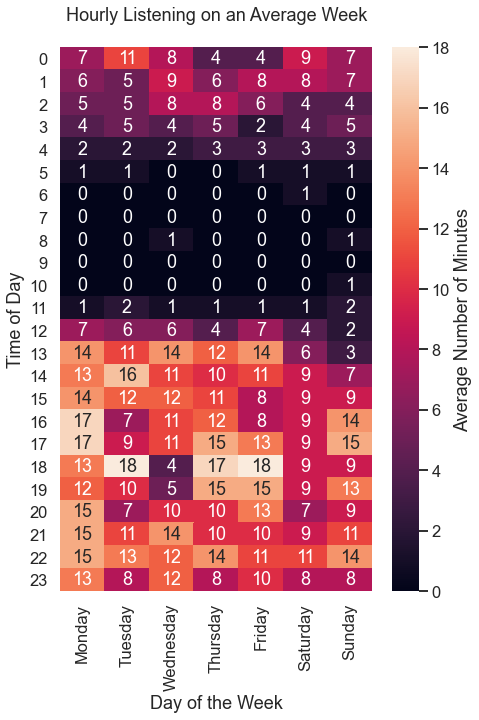

In [15]:
fig, ax = plt.subplots(figsize=(7,10))

sns.heatmap((weekly_df / 52).applymap(round), ax=ax, annot=True,cbar_kws={'label': 'Average Number of Minutes'})
plt.yticks(rotation=0)
ax.set_ylabel('Time of Day')
ax.set_xlabel('Day of the Week')
ax.set_title('Hourly Listening on an Average Week\n')
plt.savefig('weekly.pdf', bbox_inches='tight')